# Sigma点卡尔曼滤波器

> 海洋学院，沈浙奇，2024年6月，zqshen@hhu.edu.cn

当开始讨论EnKF的不足的时候，其实已经进入了更前沿的领域。从科研的角度，我们针对一个问题，提出一种可行的解决方法，然后这种方法又有其局限性。接下来以介绍为主，不涉及过细的细节，详细可以从一些论文和教材中找到。

我们来看EnKF的思想：它本质上还是在分析阶段实现卡尔曼滤波器中的更新公式

$$x^a = x^b+BH^T(R+HBH^T)^{-1}(y-Hx^b)     \qquad (1)$$

这个公式和三维变分也是一致的。然而，为了给出$B$矩阵以及让$B$矩阵随着时间演化，EnKF需要积分一整个集合，使用集合的统计信息来计算误差协方差矩阵如下：

$$\begin{gathered}
P_{\mathrm{e},k}^{\mathrm{f}}\equiv\frac{1}{N-1}\sum_{i=1}^{N}\Bigl(x_{k,i}^{\mathrm{f}}-\overline{{x_{k}^{\mathrm{f}}}}\Bigr)\Bigl(x_{k,i}^{\mathrm{f}}-\overline{{x_{k}^{\mathrm{f}}}}\Bigr)^{\mathrm{T}} \\
=\frac{1}{N-1}\Big(X_{k}^{\mathrm{f}}-\overline{{X_{k}^{\mathrm{f}}}}\Big)\Big(X_{k}^{\mathrm{f}}-\overline{{X_{k}^{\mathrm{f}}}}\Big)^{\mathrm{T}} 
\end{gathered}  \qquad (2)$$

把这里得到的$P_{\mathrm{e},k}^{\mathrm{f}}$放到（1）式中代替$B$就能实现同化。

一个现实问题是：集合成员是怎么构造的。

在我们之前的Lorenz63模式的实验中，我们是随机扰动构造的集合成员们，即`xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)`。这意味着我们对相同的初始状态`x0b`叠加符合设置的随机噪声来产生这些集合成员。然后集合成员的总数$N$也是我们自主设定的。在Lorenz63模式的实验中，这个方式运行良好。但是，正如我前面说的，伴随着随机的是不确定性，以及算法实验不一定稳定可重复。有没有一种确定的方式告诉我们几个集合成员能达成令人满意的同化效果呢？

其实是有的，这就是sigma点卡尔曼滤波器(SPKF)解决的问题。SPKF实质上就是用确定性的方式产生集合成员的方法。SPKF产生的这些集合成员在使用非线性模式传播或者非线性观测算子投影之后，能够最大程度地准确估计误差协方差矩阵。下面这张图可以大致说明其中原理。

![fig2](pic/SPKF.png)
> 对非线性传播算子分别使用 EKF 中的线性化方法和 sigma 点卡尔曼滤波器中的 SUT 得 到结果的不同均值和协方差(van der Merwe et al.，2004)

sigma点的数目理论上是$2*L+1$个，其中$L$是状态空间维数。由于模式积分要考虑模式误差(误差协方差矩阵为$Q$)，观测算子要考虑观测误差(误差协方差矩阵为$R$)，这两者也都是3维，所以$L$取9,sigma点一共19个。sigma点的产生有特殊的公式，具体产生方式如下：

In [1]:
import numpy as np
def generate_SigmaP(xb,B,Q,R):                      # 生成sigma点，构建集合
    import scipy                                               #导入scipy工具包
    n = xb.shape[0]                                           # n-状态维数                
    m = R.shape[0]                                           # m-观测误差维数                 
    L = 2*n+m;                                                  # L-离散空间状态向量维数               
    kappa=0;alpha=1;beta0=2                          # 确定UKF的参数κ、α、β
    lam = alpha**2*(L+kappa)-L  
    wm = 0.5/(L+lam)*np.ones(2*L+1)               # 计算sigam点权重
    wm[0] = lam/(L+lam)
    wc = 0.5/(L+lam)*np.ones(2*L+1)                 # 计算sigam点权重
    wc[0] = lam/(L+lam)+(1-alpha**2+beta0)
    
    theta = np.concatenate([xb,np.zeros(n+m)])  # 扩充状态向量
    Pa = scipy.linalg.block_diag(B,Q,R)                 # 计算背景误差协方差
    sqP=np.linalg.cholesky(Pa)
    SigmaP = np.zeros([L,2*L+1])
    SigmaP[:,0] = theta                                          # 生成sigma点
    SigmaP[:,1:(L+1)] = theta.reshape(-1, 1) + np.sqrt(L+lam)*sqP
    SigmaP[:,(L+1):(2*L+1)] = theta.reshape(-1, 1) - np.sqrt(L+lam)*sqP   
    xbi = SigmaP[0:n,:]; vi = SigmaP[n:2*n,:]; ni = SigmaP[2*n::,:]
    return xbi,vi,ni,wm,wc

def update_SigmaP(xbi,wm,wc,yo,ObsOp,ni):
    n,N = xbi.shape                                                # n-状态维数，N-集合成员数
    m = yo.shape[0]                                                 # m-观测维数
    ybi = np.zeros([m,N])                                        # 预分配空间，保存扰动后的观测集合
    for i in range(N):                                               # 将状态集合投影道观测空间，构成观测集合
           ybi[:,i] = ObsOp(xbi[:,i])+ni[:,i]
    xbm = np.sum(xbi*wm,1)                                   # 利用sigma点权重计算集合平均
    ybm = np.sum(ybi*wm,1)
    Pxx = (xbi-xbm.reshape(-1,1))*wc@(xbi-xbm.reshape(-1,1)).T # 计算需要的协方差矩阵
    Pyy = (ybi-ybm.reshape(-1,1))*wc@(ybi-ybm.reshape(-1,1)).T
    Pxy = (xbi-xbm.reshape(-1,1))*wc@(ybi-ybm.reshape(-1,1)).T
        
    K = Pxy @ np.linalg.inv(Pyy)                               #计算卡尔曼增益矩阵
    xa = xbm + K @ (yo-ybm)                                 # 更新状态变量
    B = Pxx-K @ Pyy @K.T                                      # 计算下一个同化循环需要的背景误差协方差
    return xa,B

至于测试SPKF，其流程就和前面所有的方法一样了。定义模式和产生观测的流程都一致：

In [2]:
# 定义模式方程和积分格式
import numpy as np
def Lorenz63(state,*args):       #Lorenz63模式
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state 
    f = np.zeros(3) 
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f 
def RK4(rhs,state,dt,*args):    # Runge-Kutta格式，输入的rhs代表模式右端方程
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args) # 输出新的一步的状态
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

# 之后使用 RK4(Lorenz63,x_in,dt,sigma,beta,rho)可以进行步长为dt的一步积分

In [3]:
# Lorenz63模式真值试验和观测构造
sigma = 10.0; beta = 8.0/3.0; rho = 28.0          # 模式参数值   
dt = 0.01                                         # 模式积分步长
n = 3                                             # 模式的状态维数，即有多少个状态变量
m = 3                                             # 模式的观测维数，即多少个变量可以被观测到，这里先假定所有变量都能被观测
tm = 10                                           # 同化试验时间窗口
nt = int(tm/dt)                                   # 总积分步数
t = np.linspace(0,tm,nt+1)                        # 模式时间网格
x0True = np.array([1.508870, -1.531271, 25.46091])# 真实值的初值
np.random.seed(seed=1)              # 设置随机种子，由于电脑的随机数是伪随机，记录了随机种子之后，每次运行这个脚本产生的“随机”的观测误差都是一样的。
sig_m= 0.5                                        # 观测误差标准差
R = sig_m**2*np.eye(n)                            # 观测误差协方差矩阵，设为对角阵使得不同变量的误差互不相干
dt_m = 0.2                                        # 观测之间的时间间隔（即每20模式步观测一次）
tm_m = 10                                         # 最大观测时间（即多少时间之后停止同化，可小于同化试验时间窗口）
nt_m = int(tm_m/dt_m)                             # 进行同化的总次数
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)   # 这是有观测的时刻在总时间网格中的位置指标
t_m = t[ind_m]                                                      # 观测网格
def h(x):                                         # 定义观测算子：观测算子用于构建模式变量和观测之间的关系。当所有变量被观测时，使用单位阵。
    H = np.eye(n)                                 # 观测矩阵为单位阵。
    yo = H@x                                      # 单位阵乘以状态变量，即所有变量直接被观测。
    return yo
Xtrue = np.zeros([n,nt+1])                        # 真值保存在xTrue变量中
Xtrue[:,0] = x0True                               # 初始化真值
km = 0                                            # 观测计数
yo = np.zeros([3,nt_m])                           # 观测保存在yo变量中
for k in range(nt):                               # 按模式时间网格开展模式积分循环
    Xtrue[:,k+1] = RK4(Lorenz63,Xtrue[:,k],dt,sigma,beta,rho)       # 真实值积分
    if (km<nt_m) and (k+1==ind_m[km]):                              # 用指标判断是否进行观测
        yo[:,km] = h(Xtrue[:,k+1]) + np.random.normal(0,sig_m,[3,]) # 通过判断，在观测时间取出真值作为观测值，同时叠加高斯分布随机噪声
        km = km+1                                                   # 观测计数，用于循环控制
        
# 这个脚本产生了同化实验中的观测数据yo和用于对比结果的真值Xtrue。

由于使用SPKF的时候考虑模式误差和不考虑模式误差有一定的差别，所以这里的模式积分都使用包含随机模式误差的那种。

In [4]:
x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
Q = 0.01*np.eye(3)                        # 设置模式误差（若假设完美模式则取0）
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)+ np.random.multivariate_normal(np.zeros(n), Q)
    # 不加同化的背景积分结果，后面和同化结果进行对比，现在考虑模式积分过程中的随机模式误差。
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵
Xa = np.zeros([3,nt+1]); Xa[:,0] = x0b   # 同化试验结果存在Xa中，第一步没同化，所以数值也是x0b
#!!!!!!!!!!!!!!!!!!!!!!!!!
xbi,vi,ni,wm,wc = generate_SigmaP(Xa[:,0], B, Q, R)     # 根据初始条件生成sigma点构成集合，并且带有权重
n,N = xbi.shape                                         # N集合成员数
#!!!!!!!!!!!!!!!!!!!!!!!!
km = 0                                   # 同化次数计数
H = np.eye(3)                            # 如前述，观测算子是单位阵
for k in range(nt):                      # 模式积分循环
    for i in range(N):                                                # 积分sigma点
        xbi[:,i] = RK4(Lorenz63,xbi[:,i],dt,sigma,beta,rho) \
                 + np.random.multivariate_normal(np.zeros(n), Q)      
    Xa[:,k] = np.sum(xbi*wm,1)                                        # sigma点的加权值是分析
    if (km<nt_m) and (k+1==ind_m[km]):                                # 当有观测时
        xbi = xbi + vi                                                # 在集合成员中加入背景误差
        Xa[:,k+1],B = update_SigmaP(xbi, wm, wc, yo[:,km], h, ni)     # 调用SP-UKF同化
        xbi,vi,ni,wm,wc = generate_SigmaP(Xa[:,k+1], B, Q, R)         # 为下一个同化循环生成集合成员
        km = km+1

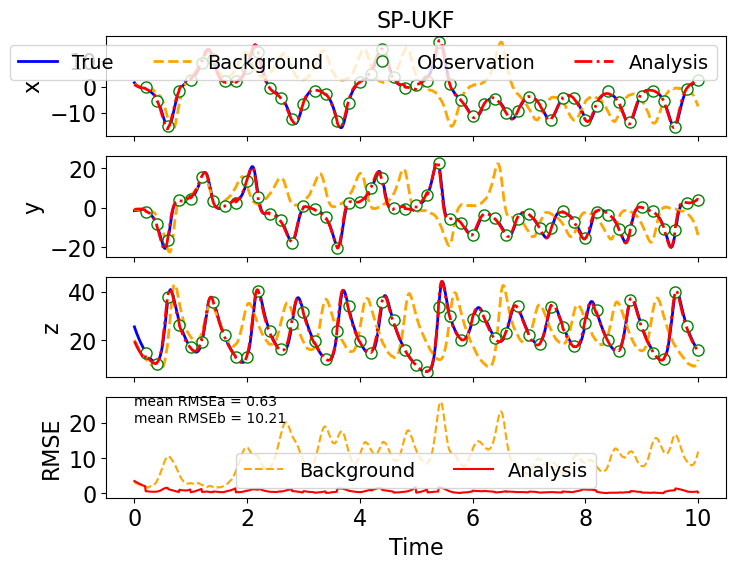

In [6]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
# 结果画图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
lbs = ['x','y','z']
for j in range(3):
    plt.subplot(4,1,j+1)
    plt.plot(t,Xtrue[j],'b-',lw=2,label='True')
    plt.plot(t,Xb[j],'--',color='orange',lw=2,label='Background')
    plt.plot(t_m,yo[j],'go',ms=8,markerfacecolor='white',label='Observation')
    plt.plot(t,Xa[j],'-.',color='red',lw=2,label='Analysis')
    plt.ylabel(lbs[j],fontsize=16)
    plt.xticks(np.arange(0,10.1,2),[]);plt.yticks(fontsize=16)
    if j==0:
        plt.legend(ncol=4, loc='upper right',fontsize=14)
        plt.title("SP-UKF",fontsize=16)     #!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.subplot(4,1,4)
plt.plot(t,RMSEb,'--',color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,20,'mean RMSEb = %0.2f' %np.mean(RMSEb))
plt.text(0,25,'mean RMSEa = %0.2f' %np.mean(RMSEa))
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.legend(ncol=4, loc=8,fontsize=14)

## 一些讨论

实际上，当前设置下，SPKF的优势并不能体现。相比于EKF，它当然更好；但是相比于EnKF，可能还需要进一步设置实验条件（如更强的非线性，或者更大的模式误差等）才能体现其优势。

而且当模式的维数较大的时候，$2L+1$的集合成员数其实也是非常大的（相对于EnKF中采用数十到数百个），所以在大型模式中SPKF现在并不实用。

但是无论如何，Sigma点提供了一种产生集合的思想，在一些研究中有借鉴价值。也是一条值得研究下去的道路。